In [68]:
import pandas as pd
from imdb import IMDBDataset
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

# Points of interest

- energy / synapse (fJ) (energy / param)
- energy / input vector (μJ)
- Power (W)
- Throughput (vectors / s)
- Power / synapse (mW) (power / param)
- Synapses (params)
- Dataset size
- Training time (s)
- Epochs

In [4]:
imdb_dataset = IMDBDataset()
imdb_size = len(imdb_dataset)
imdb_size

25000

In [44]:
mnist_size = 60000
imdb_size = 25000
batch_size = 64

In [69]:
def load_benchmark_df(filename, batch_size = 64):
    df = pd.read_csv(filename)
    num_params = df.total_params.iloc[0]
    df = df.sort_values(by=["run", "epoch", "elapsed_time"])
    df["iteration_time"] = (
        df.groupby(["run", "epoch"])["elapsed_time"].diff().fillna(0)
    )
    iteration_energy = df["power_consumption"] * df["iteration_time"]
    df["energy_J"] = iteration_energy
    energy_per_vector = iteration_energy / batch_size
    df["energy_per_vector_uJ"] = energy_per_vector * 10e6
    df["energy_per_param_fJ"] = energy_per_vector / num_params * 10e15
    df["power_per_param_mW"] = df["power_consumption"] / (batch_size * num_params) * 1000
    return df


def get_summary_df(df, dataset_size):
    results = []
    run_groups = df.groupby(["run"])
    for (run,), run_df in run_groups:
        epoch_group = run_df.groupby(["epoch"])
        train_duration = epoch_group["elapsed_time"].max().sum()
        epochs = len(epoch_group)
        
        mean_power = run_df["power_consumption"].mean()
        mean_energy_per_param = run_df["energy_per_param_fJ"].mean()
        mean_energy_per_vector = run_df["energy_per_vector_uJ"].mean()
        power_per_param = run_df["power_per_param_mW"].mean()
        run_energy = run_df["energy_J"].sum()
        params = run_df.total_params.iloc[0]
        iterations = len(run_df)

        energy_per_param_std = run_df["energy_per_param_fJ"].std()
        
        results.append({
            "run": run,
            "energy_per_param_fJ": mean_energy_per_param,
            "energy_per_param_std": energy_per_param_std,
            "energy_per_vector_uJ": mean_energy_per_vector,
            "power_W": mean_power,
            
            "train_duration_s": train_duration,
            "epochs": epochs,
            "params": params,
            "power_per_param_mW": power_per_param,
            "energy_J": run_energy,
            "iterations": iterations,
        })

    run_groups = df.groupby(["run"])["energy_per_param_fJ"]
    energy_per_param = [g.values for name, g in run_groups]
    f_statistic, p_value = f_oneway(*energy_per_param)
        
    summary = pd.DataFrame(results)

    summary["dataset_size"] = dataset_size
    summary["throughput"] = dataset_size * summary.epochs.iloc[0] / summary["train_duration_s"]
    
    return summary

# Summaries

## 4060

In [7]:
filename = "benchmarks/lstm_benchmark_cuda.csv"
df = load_benchmark_df(filename)
lstm_df = get_summary_df(df, imdb_size)
lstm_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_mJ
0,37.402546,106.926667,5.0,4828930.0,0.007746,3987.866067,1955.0,2.039829e+15,25000.0,233.808405,0.033118


In [8]:
filename = "benchmarks/transformer_benchmark_cuda.csv"
df = load_benchmark_df(filename)
transformer_df = get_summary_df(df, imdb_size)
transformer_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_mJ
0,42.444425,89.33,5.0,4172034.0,0.010174,3785.157833,1955.0,1.936142e+15,25000.0,279.862132,0.036352


In [9]:
filename = "benchmarks/resnet18_benchmark_cuda.csv"
df = load_benchmark_df(filename)
resnet18_df = get_summary_df(df, mnist_size)
resnet18_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_mJ
0,19.208431,643.24,5.0,11181642.0,0.001718,12348.1334,4690.0,2.632864e+15,60000.0,93.277836,0.018411


In [10]:
lstm_df.to_excel("lstm_4060.xlsx", index=False)
transformer_df.to_excel("transformer_4060.xlsx", index=False)
resnet18_df.to_excel("resnet18_4060.xlsx", index=False)

In [97]:
lstm_df["energy_J"] / lstm_df["params"]

0    0.000823
dtype: float64

In [2]:
df = pd.read_excel("resnet18_4060.xlsx")
df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_mJ
0,19.208431,643.24,5,11181642,0.001718,12348.1334,4690,2632864264392324,60000,93.277836,0.018411


## NPU

In [9]:
filename = "benchmarks/lstm_benchmark_npu.csv"
df = load_benchmark_df(filename)
lstm_df = get_summary_df(df, imdb_size)
lstm_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,1.411765,1174.063333,5.0,4828930.0,0.000292,1615.515333,1955.0,8.263506e+14,25000.0,21.315039,0.013761


In [10]:
filename = "benchmarks/resnet18_benchmark_npu.csv"
df = load_benchmark_df(filename)
resnet18_df = get_summary_df(df, mnist_size)
resnet18_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,3.474271,2915.513333,5.0,11181642.0,0.000311,9880.115667,4690.0,2.106634e+15,60000.0,20.612039,0.015072


In [11]:
filename = "benchmarks/transformer_benchmark_npu.csv"
df = load_benchmark_df(filename)
transformer_df = get_summary_df(df, imdb_size)
transformer_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,0.999761,1270.51,5.0,4172034.0,0.00024,1200.332,1955.0,6.139806e+14,25000.0,19.744585,0.012384


In [15]:
lstm_df.to_excel("lstm_npu.xlsx", index=False)
transformer_df.to_excel("transformer_npu.xlsx", index=False)
resnet18_df.to_excel("resnet18_npu.xlsx", index=False)

# NPU New (from IVI)

In [4]:
filenames = [(f"benchmarks/{model}_benchmark_npu_new.csv", model) for model in ["lstm", "resnet18", "transformer"]]
dataset_sizes = {
    "lstm": imdb_size,
    "transformer": imdb_size,
    "resnet18": mnist_size
}

for filename, model in filenames:
    df = load_benchmark_df(filename)
    dataset_size = dataset_sizes[model]
    summary_df = get_summary_df(df, dataset_size)
    summary_df.to_excel(f"summaries/{model}_npu_new.xlsx", index=False)

## A100

In [4]:
filename = "benchmarks/lstm_benchmark_cuda_a100.csv"
df = load_benchmark_df(filename)
lstm_df = get_summary_df(df, imdb_size)
lstm_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,0.204738,387.726667,5.0,4828930.0,0.000042,77.272967,1955.0,3.952581e+13,25000.0,64.481289,0.000658


In [4]:
filename = "benchmarks/resnet18_benchmark_cuda_a100.csv"
df = load_benchmark_df(filename)
resnet18_df = get_summary_df(df, mnist_size)
resnet18_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,167.379107,257.136667,5.0,11181642.0,0.014969,38514.3774,590.0,6.527861e+16,60000.0,233.402216,0.064158


In [6]:
filename = "benchmarks/transformer_benchmark_cuda_a100.csv"
df = load_benchmark_df(filename)
transformer_df = get_summary_df(df, imdb_size)
transformer_df

,mean_power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,energy_per_param_fJ,dataset_size,throughput,energy_per_vector_uJ
0,0.21896,377.86,5.0,4172034.0,0.000052,79.976767,1955.0,4.090883e+13,25000.0,66.171208,0.000793


In [8]:
lstm_df.to_excel("summaries/lstm_a100.xlsx", index=False)
transformer_df.to_excel("summaries/transformer_a100.xlsx", index=False)
resnet18_df.to_excel("summaries/resnet18_a100.xlsx", index=False)

### Max (512 batch size, 4 workers)

In [7]:
filenames = [(f"benchmarks/{model}_benchmark_cuda_a100_max.csv", model) for model in ["lstm", "resnet18", "transformer"]]
dataset_sizes = {
    "lstm": imdb_size,
    "transformer": imdb_size,
    "resnet18": mnist_size
}

for filename, model in filenames:
    df = load_benchmark_df(filename)
    dataset_size = dataset_sizes[model]
    summary_df = get_summary_df(df, dataset_size)
    summary_df.to_excel(f"summaries/{model}_cuda_a100_max.xlsx", index=False)

<Axes: ylabel='power_consumption'>

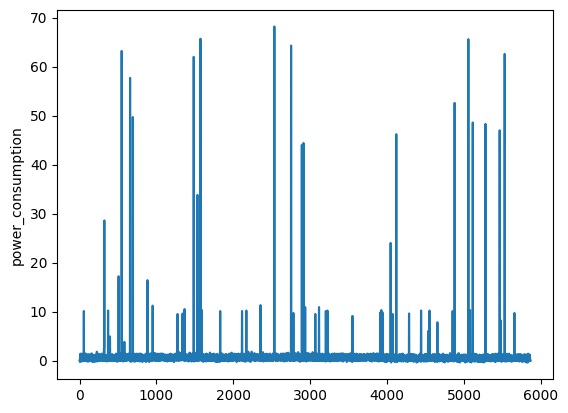

In [14]:
import seaborn as sns

df = pd.read_csv("benchmarks/lstm_benchmark_npu.csv")
sns.lineplot(x=np.arange(0, len(df)), y=df["power_consumption"])


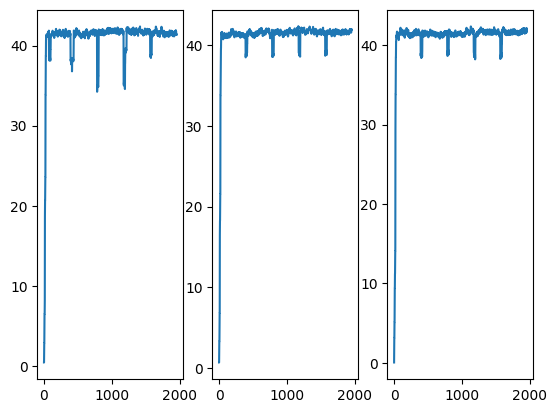

In [41]:
df = pd.read_csv("benchmarks/lstm_benchmark_cuda.csv")
fig, axs = plt.subplots(1, 3)
for i in range(3):
    run_df = df[df["run"] == i]
    axs[i].plot(np.arange(0, len(run_df)), run_df["power_consumption"])


In [42]:
df.groupby(["run"])[["power_consumption", "accuracy", "avg_loss"]].mean()

,power_consumption,accuracy,avg_loss
run,,,
0,40.932102,0.509311,0.691681
1,41.055105,0.527613,0.671575
2,41.077146,0.526231,0.671523
3,41.198813,0.529436,0.669492
4,41.046859,0.529468,0.673935


<Axes: ylabel='power_consumption'>

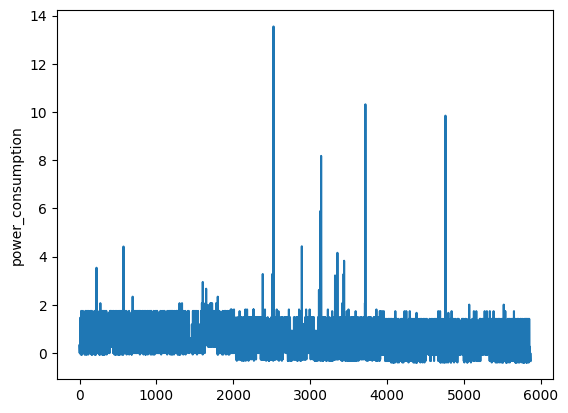

In [25]:
df = pd.read_csv("benchmarks/lstm_benchmark_cuda_a100.csv")
sns.lineplot(x=np.arange(0, len(df)), y=df["power_consumption"])

In [17]:
df = df[df["run"] == 0]
epoch_group = df.groupby(["epoch"])
epoch_group["power_consumption"].mean()

epoch
0    0.285575
1    0.344936
2    0.333478
3    0.399412
4    0.442379
Name: power_consumption, dtype: float64

In [19]:
epoch_group["elapsed_time"].max().sum()

np.float64(389.35)

In [27]:
df = load_benchmark_df("benchmarks/lstm_benchmark_cuda_a100.csv")
df

,run,epoch,elapsed_time,power_consumption,accuracy,avg_loss,total_params,iteration_time,energy_J
0,0,0,0.65,0.33,51.108,0.765064,4828930,0.00,0.0000
1,0,0,0.84,0.00,51.108,0.765064,4828930,0.19,0.0000
2,0,0,1.01,0.00,51.108,0.765064,4828930,0.17,0.0000
3,0,0,1.17,0.33,51.108,0.765064,4828930,0.16,0.0528
4,0,0,1.35,0.00,51.108,0.765064,4828930,0.18,0.0000
...,...,...,...,...,...,...,...,...,...
5860,2,4,80.45,-0.33,51.000,0.762305,4828930,0.20,-0.0660
5861,2,4,80.65,0.00,51.000,0.762305,4828930,0.20,0.0000
5862,2,4,80.85,-0.07,51.000,0.762305,4828930,0.20,-0.0140
5863,2,4,81.05,-0.33,51.000,0.762305,4828930,0.20,-0.0660


<Axes: ylabel='power_consumption'>

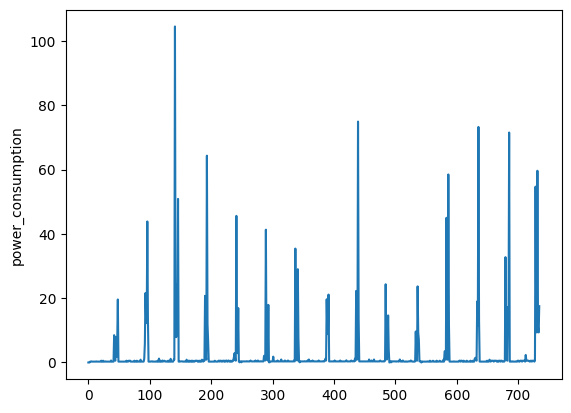

In [5]:
df = pd.read_csv("benchmarks/lstm_benchmark_cuda_a100_max.csv")
sns.lineplot(x=np.arange(0, len(df)), y=df["power_consumption"])

# Stats

In [10]:
filename = "benchmarks/lstm_benchmark_cuda.csv"
df = load_benchmark_df(filename)
df

,run,epoch,elapsed_time,power_consumption,accuracy,avg_loss,total_params,iteration_time,energy_J
0,0,0,0.31,1.57,50.140,0.693165,4828930,0.00,0.0000
1,0,0,0.37,2.14,50.140,0.693165,4828930,0.06,0.1284
2,0,0,0.43,2.14,50.140,0.693165,4828930,0.06,0.1284
3,0,0,0.48,6.50,50.140,0.693165,4828930,0.05,0.3250
4,0,0,0.54,6.50,50.140,0.693165,4828930,0.06,0.3900
...,...,...,...,...,...,...,...,...,...
5860,2,4,21.34,36.62,50.928,0.755613,4828930,0.05,1.8310
5861,2,4,21.40,36.62,50.928,0.755613,4828930,0.06,2.1972
5862,2,4,21.45,36.15,50.928,0.755613,4828930,0.05,1.8075
5863,2,4,21.51,36.15,50.928,0.755613,4828930,0.06,2.1690


In [12]:
run_df = df[df.run == 0]
run_df

,run,epoch,elapsed_time,power_consumption,accuracy,avg_loss,total_params,iteration_time,energy_J
0,0,0,0.31,1.57,50.14,0.693165,4828930,0.00,0.0000
1,0,0,0.37,2.14,50.14,0.693165,4828930,0.06,0.1284
2,0,0,0.43,2.14,50.14,0.693165,4828930,0.06,0.1284
3,0,0,0.48,6.50,50.14,0.693165,4828930,0.05,0.3250
4,0,0,0.54,6.50,50.14,0.693165,4828930,0.06,0.3900
...,...,...,...,...,...,...,...,...,...
1950,0,4,21.17,42.85,50.14,0.693165,4828930,0.06,2.5710
1951,0,4,21.22,42.85,50.14,0.693165,4828930,0.05,2.1425
1952,0,4,21.28,42.89,50.14,0.693165,4828930,0.06,2.5734
1953,0,4,21.33,42.52,50.14,0.693165,4828930,0.05,2.1260


In [17]:
epoch_group = run_df.groupby(["epoch"])
epoch_durations = epoch_group["elapsed_time"].max()
epoch_mean_powers = epoch_group["power_consumption"].mean()

print(epoch_durations, epoch_mean_powers)

epoch
0    21.34
1    21.19
2    21.25
3    21.26
4    21.37
Name: elapsed_time, dtype: float64 epoch
0    40.695345
1    42.558363
2    42.649898
3    42.713478
4    42.685064
Name: power_consumption, dtype: float64


In [26]:
models = ["lstm", "resnet18", "transformer"]
platforms = ["cuda_a100", "cuda", "npu"]
dataset_sizes = {
    "lstm": imdb_size,
    "transformer": imdb_size,
    "resnet18": mnist_size
}

results = []
for platform in platforms:
    for model in models:
        benchmark_filename = f"benchmarks/{model}_benchmark_{platform}.csv"
        bench_df = load_benchmark_df(benchmark_filename)
        dataset_size = dataset_sizes[model]
        summary_df = get_summary_df(bench_df, dataset_size)
        summary_filename = f"summaries/new/{model}_{platform}.xlsx"
        summary_df.to_excel(summary_filename, index=False)

        results.append({
            "energy_per_syn_fj": summary_df
        })

In [63]:
filename = "benchmarks/lstm_benchmark_cuda.csv"
dataset_size = imdb_size
df = load_benchmark_df(filename)
run_groups = df.groupby(["run"])["energy_per_param_fJ"]
energy_per_param = [g.values for name, g in run_groups]
f_statistic, p_value = f_oneway(*energy_per_param)

In [64]:
f_statistic

np.float64(2.2144075140552673)

In [65]:
p_value

np.float64(0.06484036454919631)

In [67]:
filename = "benchmarks/lstm_benchmark_cuda.csv"
dataset_size = imdb_size
df = load_benchmark_df(filename)
summary_df = get_summary_df(df, dataset_size)
summary_df

,run,energy_per_param_fJ,energy_per_param_std,energy_per_vector_uJ,power_W,train_duration_s,epochs,params,power_per_param_mW,energy_J,iterations,dataset_size,throughput
0,0,5.762473e+07,9.722703e+06,278265.808824,40.932102,85.80,5,4828930,0.000132,3481.6618,1955,25000,1456.876457
1,1,5.802180e+07,8.393543e+06,280183.200128,41.055105,85.87,5,4828930,0.000133,3505.6522,1955,25000,1455.688832
2,2,5.772081e+07,8.417943e+06,278729.739450,41.077146,85.38,5,4828930,0.000133,3487.4665,1955,25000,1464.043101
3,3,5.837131e+07,8.274726e+06,281870.955882,41.198813,86.07,5,4828930,0.000133,3526.7694,1955,25000,1452.306262
4,4,5.791896e+07,8.435637e+06,279686.620844,41.046859,85.72,5,4828930,0.000133,3499.4390,1955,25000,1458.236118
